In [64]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta

def date2int(date_obj):
    string = str(date_obj)
    return int("".join(string.split(" ")[0].split("-")))

def delete_zero(df):
    for i in df:
        df[i] = df[i].fillna(0)
        if (df[i] == 0).all():
            del df[i]
    return df

In [264]:
df_5_13 = pd.read_csv("./Data/df_5_13.csv", index_col=0, dtype={"date": int})
df_10_20 = pd.read_csv("./Data/df_10_20.csv", index_col=0, dtype={"date": int})
df_20_50 = pd.read_csv("./Data/df_20_50.csv", index_col=0, dtype={"date": int})
df_50_100 = pd.read_csv("./Data/df_50_100.csv", index_col=0, dtype={"date": int})
df_index = pd.read_csv("./Data/future_index.csv", index_col=0, dtype={"data": int})
df_index = df_index[(df_index["date"] >= 20070104) & (df_index["date"] <= 20180503)]

In [243]:
NPV_df = df_5_13.copy()
NPV_df.iloc[:, 1:] = NPV_df.iloc[:, 1:] / 1e8
NPV_df = delete_zero(NPV_df)
TOTAL_TYPE = NPV_df.shape[1] - 1

In [244]:
total_npv = NPV_df.iloc[:, 1:].sum(1).cumsum() / TOTAL_TYPE

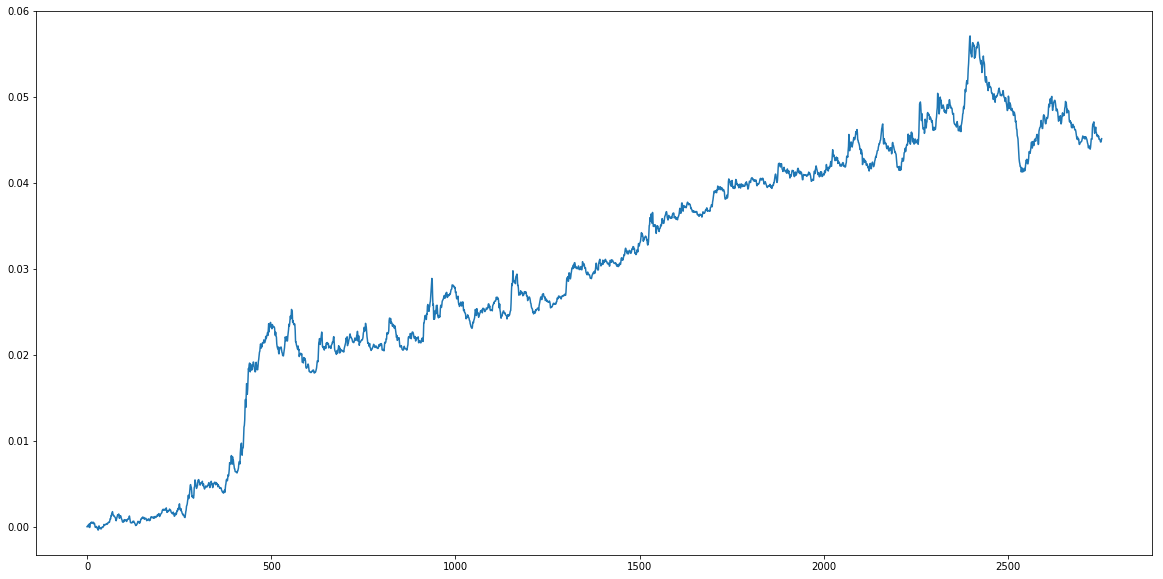

In [246]:
total_npv.plot(figsize=(20, 10))

In [247]:
H = 20
R = 50

In [249]:
# 使用历史波动率
weight = np.zeros_like(NPV_df.iloc[:, 1:])
changed = False

for idx in range(len(NPV_df) - H):
    if idx < R:
        continue
    
    if idx % H == 0:
        vol = NPV_df.iloc[idx - R : idx, 1:].std(axis=0)
        this_weight = (1 / vol) / sum(1 / vol)
        
        if this_weight.hasnans:
            this_weight = np.ones((1, TOTAL_TYPE)) / TOTAL_TYPE
        elif not changed:
            print("change to vol mode at:", idx)
            changed = True
        weight[idx : idx + H, :] = this_weight

total_npv = (weight * NPV_df.iloc[:, 1:]).sum(1).cumsum()

change to vol mode at: 2020


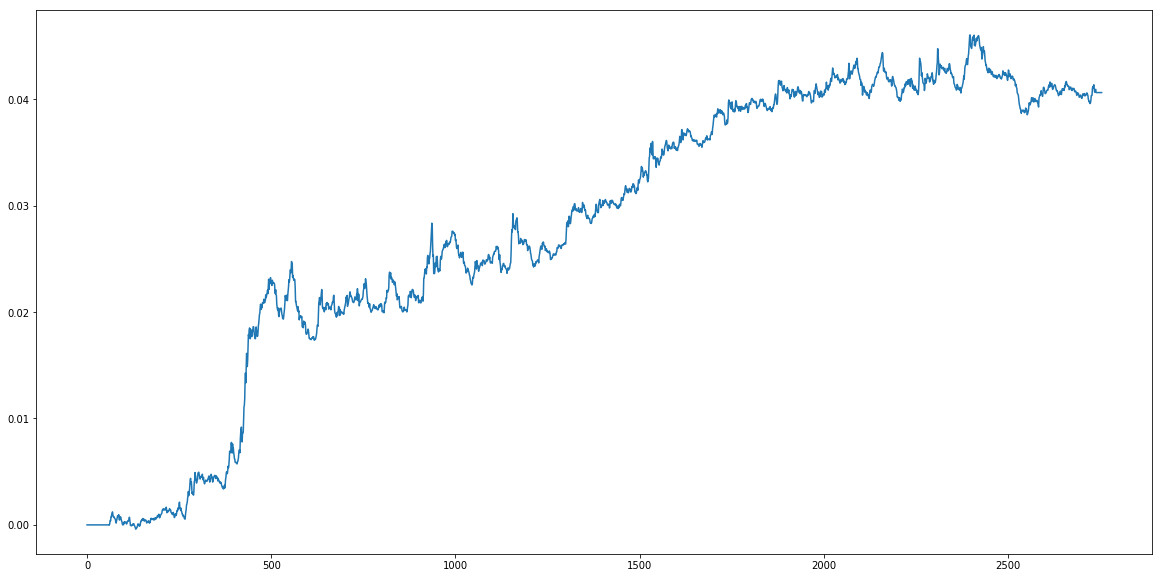

In [250]:
total_npv.plot(figsize=(20, 10))

In [267]:
t_sigma = 0.4
R = 50
df_index_pct = df_index.pct_change().fillna(0)

In [290]:
tt = None
# using realized volatility
weight = np.zeros_like(NPV_df.iloc[:, 1:])
changed = False

for idx in range(len(NPV_df) - H):
    if idx < R:
        continue
    
    if idx % H == 0:
        vol = NPV_df.iloc[idx - R : idx, 1:].std(axis=0)
        index_vol = df_index_pct.iloc[idx -R : idx, 1:].std(axis=0)
        tt = vol
        if (vol == 0.0).any() or vol.hasnans:
            this_weight = np.ones((1, TOTAL_TYPE)) / TOTAL_TYPE
        else:
            this_weight = index_vol[vol.index] * t_sigma / vol / sum(index_vol[vol.index] * t_sigma / vol)
            if not changed:
                print("change to vol mode at:", idx)
                changed = True

        weight[idx : idx + H, :] = this_weight

total_npv = (weight * NPV_df.iloc[:, 1:]).sum(1).cumsum()

change to vol mode at: 2020


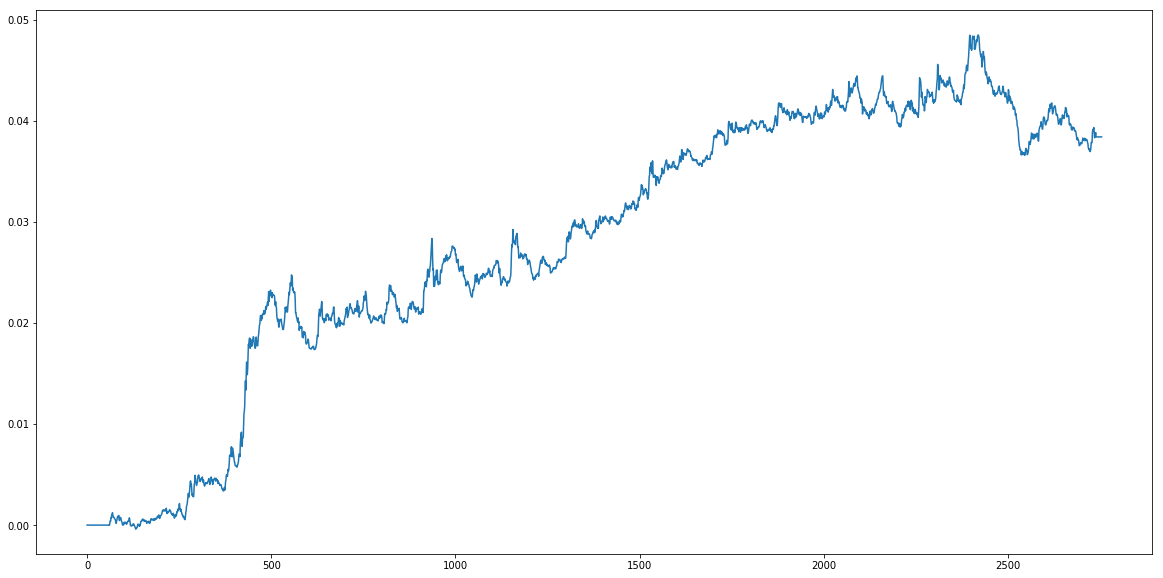

In [291]:
total_npv.plot(figsize=(20, 10))